In [64]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features , columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [65]:
# 레이블 값의 분포
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [66]:
# 80% 학습, 20% 테스트로 추출 -> 이 80% 학습데이터에서 90% 최종학습용, 10% 검증용으로 분할 -> 조기 중단 수행 하기 위함
## 맨 마지막 컬럼이 레이블임 . :-1 슬라이싱 함

X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [67]:
# 전체 중 80% 학습. 20% 테스트 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state=156)

# 위에서 만든 X_train , y_train 에 대해 90% 학습용. 10% 검증용으로 나눔.
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)


(455, 30) (114, 30)
(409, 30) (46, 30)


In [68]:
# 학습, 검증, 테스트용 DMatrix 생성.
dtr = xgb.DMatrix(data = X_tr, label=y_tr)
dval = xgb.DMatrix(data = X_val, label=y_val)
dtest = xgb.DMatrix(data = X_test, label=y_test)

In [69]:
# 하이퍼 파라미터 딕셔너리
params = {
    'max_depth':3
    ,'eta':0.05
    ,'objective':'binary:logistic'
    ,'eval_metric':'logloss'
}

num_rounds = 400

In [70]:
#학습데이터셋은 train / 평가데이터셋은 eval
eval_list = [(dtr,'train'), (dval, 'eval')]

# 조기중단 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, early_stopping_rounds = 50, evals = eval_list)

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

In [71]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시 됨')
print(np.round(pred_probs[:10], 3))

# 예측확률이 0.5보다 크면 1, 아니면 0 으로 
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 : ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시 됨
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
예측값 10개만 표시 :  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #roc_auc 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f} , AUC : {4:.4f} '.format(accuracy, precision, recall, f1, roc_auc))

In [73]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[35  2]
 [ 2 75]]
정확도 : 0.9649, 정밀도 : 0.9740, 재현율 : 0.9740, F1 : 0.9740 , AUC : 0.9965 


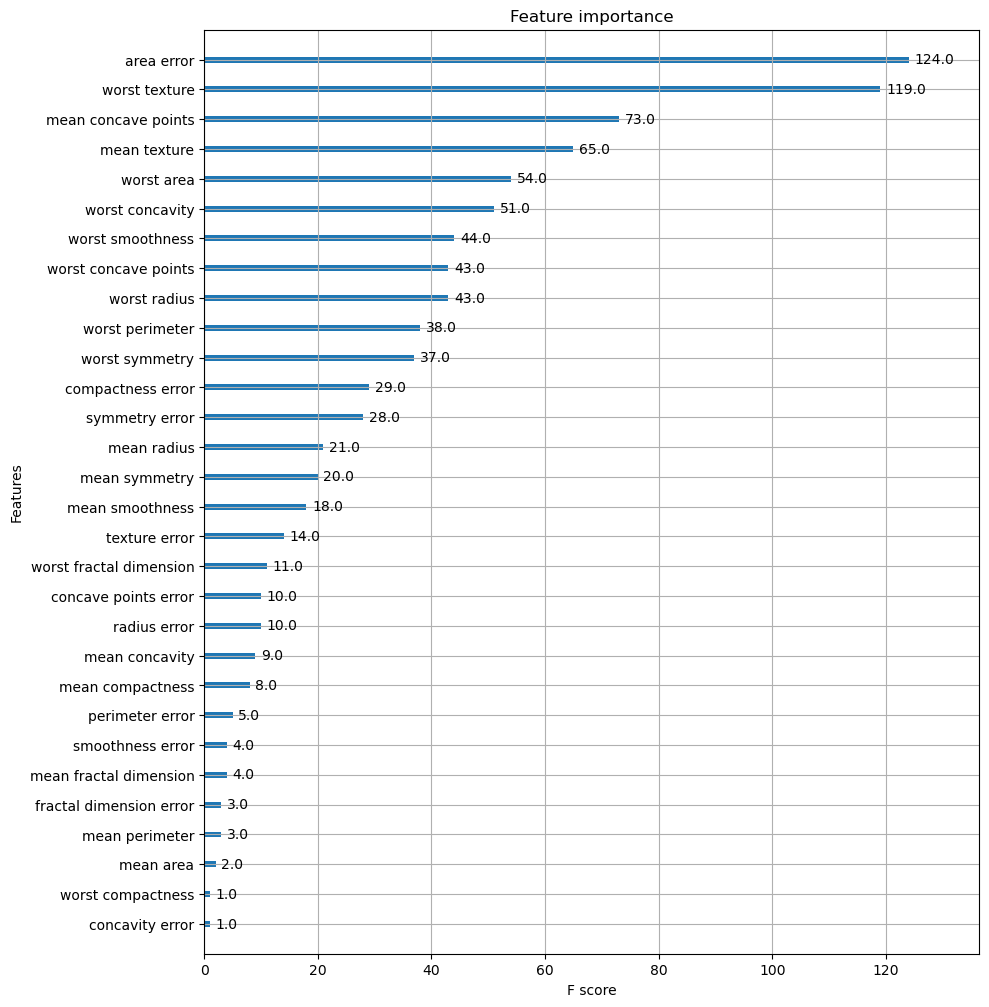

In [74]:
# xgboos 시각화
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_model, ax=ax)
plt.show()

In [75]:
##### XGBClassifier 로 예측하기
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [76]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9870, F1 : 0.9806 , AUC : 0.9954 


In [80]:
# 조기중단 적용 하기. early_stopping_rounds=10 . 50적용 시 와 비교도 필요.
evals=[(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, eval_metric='logloss', max_depth = 3, early_stopping_rounds=10)

xgb_wrapper.fit(X_train, y_train, verbose=True, eval_set=evals)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, w_preds, w_pred_proba)

[0]	validation_0-logloss:0.62456	validation_1-logloss:0.62158
[1]	validation_0-logloss:0.58665	validation_1-logloss:0.59139
[2]	validation_0-logloss:0.55183	validation_1-logloss:0.56009
[3]	validation_0-logloss:0.52052	validation_1-logloss:0.53465
[4]	validation_0-logloss:0.49177	validation_1-logloss:0.51265
[5]	validation_0-logloss:0.46552	validation_1-logloss:0.49116
[6]	validation_0-logloss:0.44048	validation_1-logloss:0.47068
[7]	validation_0-logloss:0.41739	validation_1-logloss:0.44938
[8]	validation_0-logloss:0.39592	validation_1-logloss:0.43168
[9]	validation_0-logloss:0.37589	validation_1-logloss:0.41667
[10]	validation_0-logloss:0.35726	validation_1-logloss:0.39896
[11]	validation_0-logloss:0.34026	validation_1-logloss:0.38193
[12]	validation_0-logloss:0.32406	validation_1-logloss:0.36673
[13]	validation_0-logloss:0.30894	validation_1-logloss:0.35399
[14]	validation_0-logloss:0.29484	validation_1-logloss:0.34209
[15]	validation_0-logloss:0.28146	validation_1-logloss:0.32900
[1